# SalishSeaCast 2015-2019 summary

Figs. 4, 5 and S1 from Moore-Maley and Allen, 2021, Ocean Sci.:

***

In [32]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, dates, patches, colors, gridspec
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal, fft
from tqdm.notebook import tqdm

%matplotlib inline

In [33]:
plt.rcParams['font.size'] = 12

***

## Functions and definitions

In [4]:
# Definitions
subdomain = [110, 370, 300, 850]
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data'
palette = ['powderblue', 'steelblue', 'orange', 'mistyrose']
tmask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc').tmask[0, 0, ...]
skip = 5

# Wind stress
rho_a = 1.225
theta = np.deg2rad(55.5)

# Cutoffs
cutoffs = {
    2015: [(4, 12), (8, 24)],
    2016: [(4,  7), (8, 22)],
    2017: [(4, 27), (9,  4)],
    2018: [(4,  5), (9,  2)],
    2019: [(4,  2), (9,  6)],
}

# End boxes
boxes = [
    {'name': 'DP', 'xlim': (115, 170), 'ylim': (720, 770)},
    {'name': 'BP', 'xlim': (250, 350), 'ylim': (320, 400)},
]

# Side sections
sections = [
    {'name': 'VI', 'x': [], 'y': [], 'xargs': [(130, 155, 13), (140, 240, 17)], 'yargs': [(1230, -4), (725, -1)]},
    {'name': 'SC', 'x': [], 'y': [], 'xargs': [(180, 198, 10), (170, 195, 10), (240, 285, 10)], 'yargs': [(1250, -3), (980, -2), (785, -1)]},
]
for section in sections:
    for xargs, yargs in zip(section['xargs'], section['yargs']):
        section['x'].append(np.linspace(*xargs).astype(int))
        section['y'].append((yargs[0] + yargs[1] * section['x'][-1]).astype(int))
    for var in ['x', 'y']: section[var] = np.hstack(section[var])

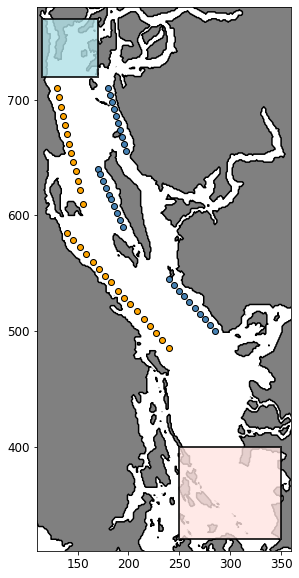

In [5]:
# Plot regions
fig, ax = plt.subplots(figsize=(6, 10))
ax.contourf(tmask, levels=[-0.01, 0.01], colors='gray')
ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
ax.set_xlim([110, 360])
ax.set_ylim([310, 780])
ax.set_aspect(5/4.4)

# Plot sections
for section, color in zip(sections, ['orange', 'steelblue']):
    ax.plot(section['x'], section['y'], 'ko', mfc=color)

# Plot boxes
for box, color in zip(boxes, ['powderblue', 'mistyrose']):
    xdx, ydy = [(box[key][0], abs(np.subtract(*box[key]))) for key in ('xlim', 'ylim')]
    ax.add_patch(patches.Rectangle((xdx[0], ydy[0]), xdx[1], ydy[1], fc=color, ec='k', lw=2, alpha=0.8, zorder=10))

***

## Load data

Load time series

In [6]:
data = {}

# Load GEM
with xr.open_dataset(f'{path}/HRDPS_1h_20141201_20200201_wind.nc') as ds:

    # Meshmask cut everything but open SoG
    landmask = ds.landmask.values
    landmask[:25, :] = 0   # San Juan Islands
    landmask[100:, :] = 0  # Discovery Islands
    landmask[:40, :50] = 0 # Left corner
    landmask[:40, 73:] = 0 # JdF/Gulf Islands
    landmask[40:, 61:] = 0 # Fraser River
    landmask[58:, 53:] = 0 # Howe Sound
    landmask[76:, 35:] = 0 # Jervis Inlet
    landmask = landmask.reshape(-1).astype('bool')

    # Load u and v wind components
    u, v = [ds[var].values.reshape(-1, len(landmask))[:, landmask] for var in ['u_wind', 'v_wind']]

# Process wind according to Hellerman and Rosenstein 1983, JPO
wspd = np.sqrt(u**2 + v**2)
v = v * np.cos(theta) - u * np.sin(theta)
tau = rho_a * calc_Cd(wspd) * v * wspd
data['wspd'] = v.mean(axis=1)
data['tau'] = tau.mean(axis=1)

# Load NEMO
slc = slice(None, None, skip)
with xr.open_dataset(f'{path}/SalishSea_1h_20141201_20200201_grid_T.nc') as ds:
    
    # Get mean data
    landmask = np.copy(tmask.values[slice(*subdomain[2:]), slice(*subdomain[:2])])
    landmask[:10, :] = 0
    landmask[450:, :] = 0
    landmask[:160, :125] = 0
    landmask[:90, :150] = 0
    landmask[90:, 200:] = 0
    landmask[280:, 130:] = 0
    landmask[400:, 70:] = 0
    landmask = landmask[slc, slc].reshape(-1).astype('bool')
    
    data['time'] = ds.time_counter.values.astype('datetime64[s]').astype(datetime)
    
    for var in tqdm(['votemper', 'nitrate']):
        data[var] = {}
        
        data[var]['full'] = ds[var].isel(y=slc, x=slc).values.reshape(-1, len(landmask))[:, landmask]
        
        # Get data at each station
        for section in sections:
            jlist, ilist = [section[dim] - subdomain[i] for dim, i in zip(['y', 'x'], [2, 0])]
            data[var][section['name']] = np.vstack([ds[var][:, j, i].values for j, i in zip(jlist, ilist)]).T
        
        # Get data in each box
        for box in boxes:
            boxslc = (slice(None),) + tuple(slice(*[lim - subdomain[i] for lim in box[dim]]) for dim, i in zip(['ylim', 'xlim'], [2, 0]))
            data[var][box['name']] = ds[var][boxslc][:, slc, slc].values

  0%|          | 0/2 [00:00<?, ?it/s]

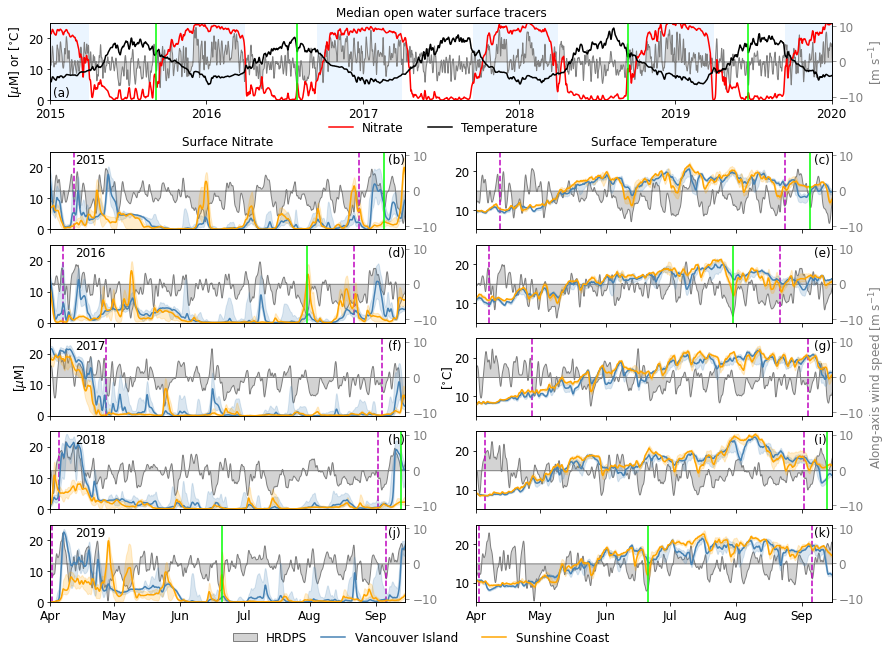

In [15]:
MODIS_dates = [
    '2015 Sep 04 21:40:00',
    '2016 Jul 30 20:35:10',
    '2018 Sep 12 21:40:01',
    '2019 Jun 20 21:30:00',
]

fig = plt.figure(figsize=(14, 10))
k = 1

gs = plt.GridSpec(6, 2, wspace=0.2)
ax = fig.add_subplot(gs[0, :])
window = signal.get_window('blackman', 120)
ax.set_title('Median open water surface tracers', fontsize=12)
ax2 = ax.twinx()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0+0.05, pos.width, pos.height])
ax.set_zorder(1)
ax.patch.set_visible(False)
ax2.set_ylim([-11, 11])
ax.set_ylim([0, 25])
ax.set_xlim([datetime(2015, 1, 1), datetime(2020, 1, 1)])
ax.set_ylabel('[$\mu$M] or [$^{\circ}$C]')
ax2.set_ylabel('[m s$^{-1}$]', color='gray')
ax2.tick_params(axis='y', colors='gray')
for year in range(2014, 2020):
    ax2.add_patch(patches.Rectangle([datetime(year, 9, 15), -11], timedelta(days=198), 22, fc=[0.92, 0.96, 1], zorder=0))
ax2.fill_between(data['time'], signal.convolve(data['wspd'], window / sum(window), mode='same'), ec='gray', fc='lightgray', label='HRDPS')
for var, label, color in zip(['nitrate', 'votemper'], ['Nitrate', 'Temperature'], ['r', 'k']):
    ax.plot(data['time'], signal.convolve(np.median(data[var]['full'], axis=1), window / sum(window), mode='same'), '-', color=color, label=label)
for date in MODIS_dates:
    date = parse(date)
    ax.plot([date, date], [0, 25], '-', color='lime')
ax.legend(loc=(0.35, -0.5), ncol=2, frameon=False)
ax.text(0.004, 0.05, '(a)', transform=ax.transAxes)

axs = [[fig.add_subplot(gs[row, col]) for col in range(2)] for row in range(1, 6)]
window = signal.get_window('blackman', 48)
for row, year in zip(axs, range(2015, 2020)):
    
    row[0].text(0.07, 0.85, year, transform=row[0].transAxes)
    for ax, var, title, units, ylim in zip(
        row, ['nitrate', 'votemper'], ['Surface Nitrate', 'Surface Temperature'], ['[$\mu$M]', '[$^{\circ}$C]'], [(0, 25), (5, 25)]
    ):
    
        index = (data['time'] > datetime(year, 1, 1)) & (data['time'] < datetime(year+1, 1, 1))
        xlim = [datetime(year, 4, 1), datetime(year, 9, 15)]

        # Set up axes
        ax.set_zorder(1)
        ax.patch.set_visible(False)
        ax2 = ax.twinx()
        ax2.set_ylim([-11, 11])
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax2.tick_params(axis='y', colors='gray')
        if year == 2017:
            ax.set_ylabel(units, labelpad=-1)
            if var == 'votemper':
                ax2.set_ylabel('Along-axis wind speed [m s$^{-1}$]', color='gray')

        ax2.fill_between(data['time'][index], signal.convolve(data['wspd'][index], window / sum(window), mode='same'), ec='gray', fc='lightgray', label='HRDPS')
        labels = ['Vancouver Island', 'Sunshine Coast']
        for region, label, color in zip(['VI', 'SC'], labels, ['steelblue', 'orange']):
            p25, p50, p75 = [signal.convolve(np.percentile(data[var][region][index], p, axis=1), window / sum(window), mode='same') for p in (25, 50, 75)]
            ax.fill_between(data['time'][index], p25, p75, fc=color, ec=color, alpha=0.2)
            ax.plot(data['time'][index], p50, '-', color=color, label=label)
            #ax.plot(data['time'][index], signal.convolve(np.median(data[var][region][index], axis=1), window / sum(window), mode='same'), '-', color=color, label=label)
        
        for cutoff in cutoffs[year]: ax2.plot(np.repeat(datetime(year, *cutoff), 2), [-11, 11], 'm--')
        for date in MODIS_dates:
            date = parse(date)
            ax.plot([date, date], [0, 25], '-', color='lime')
        ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
        if year < 2019: ax.xaxis.set_ticklabels('')
        if year == 2015: ax.set_title(f'{title}', fontsize=12)
        ax.text(0.95, 0.85, f'({chr(97+k)})', transform=ax.transAxes)
        k += 1

ax.legend(loc=(-0.45, -0.6), ncol=2, frameon=False)
ax2.legend(loc=(-0.7, -0.6), frameon=False)

#fig.savefig('/home/bmoorema/Desktop/revision_figs/timeseries.pdf', bbox_inches='tight')

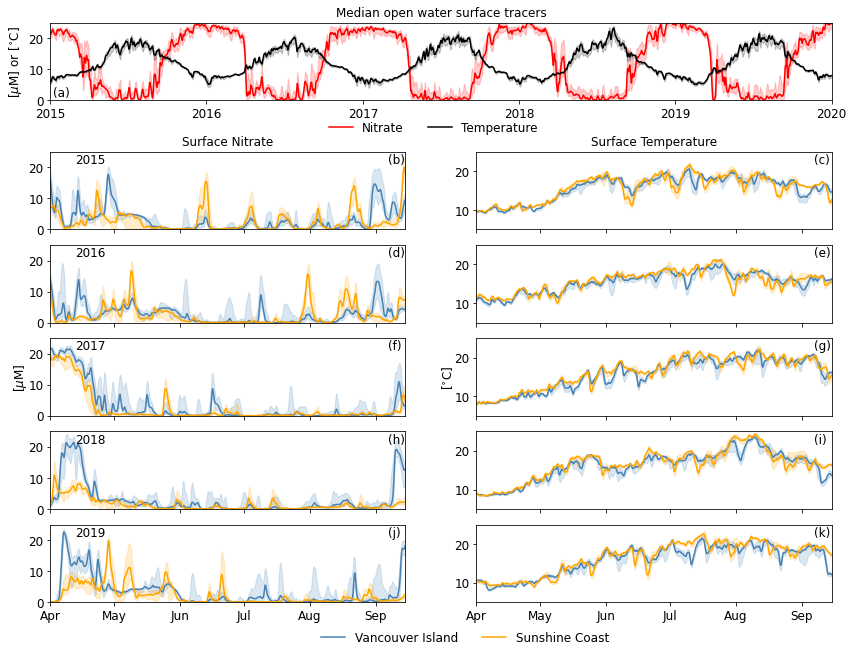

In [50]:
fig = plt.figure(figsize=(14, 10))
k = 1

gs = plt.GridSpec(6, 2, wspace=0.2)
ax = fig.add_subplot(gs[0, :])
window = signal.get_window('blackman', 120)
ax.set_title('Median open water surface tracers', fontsize=12)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0+0.05, pos.width, pos.height])
ax.set_zorder(1)
ax.patch.set_visible(False)
ax.set_ylim([0, 25])
ax.set_xlim([datetime(2015, 1, 1), datetime(2020, 1, 1)])
ax.set_ylabel('[$\mu$M] or [$^{\circ}$C]')
for var, label, color in zip(['nitrate', 'votemper'], ['Nitrate', 'Temperature'], ['r', 'k']):
    p25, p50, p75 = [signal.convolve(np.percentile(data[var]['full'], p, axis=1), window / sum(window), mode='same') for p in (25, 50, 75)]
    ax.fill_between(data['time'], p25, p75, fc=color, ec=color, alpha=0.2)
    ax.plot(data['time'], p50, '-', color=color, label=label)
ax.legend(loc=(0.35, -0.5), ncol=2, frameon=False)
ax.text(0.004, 0.05, '(a)', transform=ax.transAxes)

axs = [[fig.add_subplot(gs[row, col]) for col in range(2)] for row in range(1, 6)]
window = signal.get_window('blackman', 48)
for row, year in zip(axs, range(2015, 2020)):
    
    row[0].text(0.07, 0.85, year, transform=row[0].transAxes)
    for ax, var, title, units, ylim in zip(
        row, ['nitrate', 'votemper'], ['Surface Nitrate', 'Surface Temperature'], ['[$\mu$M]', '[$^{\circ}$C]'], [(0, 25), (5, 25)]
    ):
    
        index = (data['time'] > datetime(year, 1, 1)) & (data['time'] < datetime(year+1, 1, 1))
        xlim = [datetime(year, 4, 1), datetime(year, 9, 15)]

        # Set up axes
        ax.set_zorder(1)
        ax.patch.set_visible(False)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        if year == 2017: ax.set_ylabel(units, labelpad=-1)

        labels = ['Vancouver Island', 'Sunshine Coast']
        for region, label, color in zip(['VI', 'SC'], labels, ['steelblue', 'orange']):
            p25, p50, p75 = [signal.convolve(np.percentile(data[var][region][index], p, axis=1), window / sum(window), mode='same') for p in (25, 50, 75)]
            ax.fill_between(data['time'][index], p25, p75, fc=color, ec=color, alpha=0.2)
            ax.plot(data['time'][index], p50, '-', color=color, label=label)
        
        ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
        if year < 2019: ax.xaxis.set_ticklabels('')
        if year == 2015: ax.set_title(f'{title}', fontsize=12)
        ax.text(0.95, 0.85, f'({chr(97+k)})', transform=ax.transAxes)
        k += 1

ax.legend(loc=(-0.45, -0.6), ncol=2, frameon=False)

fig.savefig('/home/bmoorema/Desktop/revision_figs/timeseries_withIQR.pdf', bbox_inches='tight')

Load profiles

In [20]:
# Loop through year, variables and stations
landmask = np.copy(tmask.values[slice(*subdomain[2:]), slice(*subdomain[:2])])
landmask[:120, :] = 0
landmask[410:, :] = 0
landmask[:170, :130] = 0
landmask[:, 190:] = 0
landmask[280:, 130:] = 0
landmask = landmask[::10, ::10].reshape(-1).astype('bool')

profiles = {'votemper': [], 'nitrate': []}
slc = {'x': slice(*subdomain[:2], 10), 'y': slice(*subdomain[2:], 10)}
for year in range(2015, 2020):
    start, end = [datetime(year, *md) for md in cutoffs[year]]
    for day in tqdm(range((end - start).days), f'Loading {year}'):
        for var in ['votemper', 'nitrate']:
            filestr = 'ptrc_T' if var == 'nitrate' else 'grid_T'
            with xr.open_dataset(f'{nc_tools.get_hindcast_prefix(start + timedelta(day))}_{filestr}.nc') as ds:
                profiles[var].append(ds[var].isel(slc).values.reshape(24, 40, len(landmask))[..., landmask])

Loading 2015:   0%|          | 0/134 [00:00<?, ?it/s]

Loading 2016:   0%|          | 0/137 [00:00<?, ?it/s]

Loading 2017:   0%|          | 0/130 [00:00<?, ?it/s]

Loading 2018:   0%|          | 0/150 [00:00<?, ?it/s]

Loading 2019:   0%|          | 0/157 [00:00<?, ?it/s]

In [22]:
profiles2 = {}
for var in ['votemper', 'nitrate']:
    profiles2[var] = np.concatenate(profiles[var])

In [26]:
deptht = ds.deptht.values

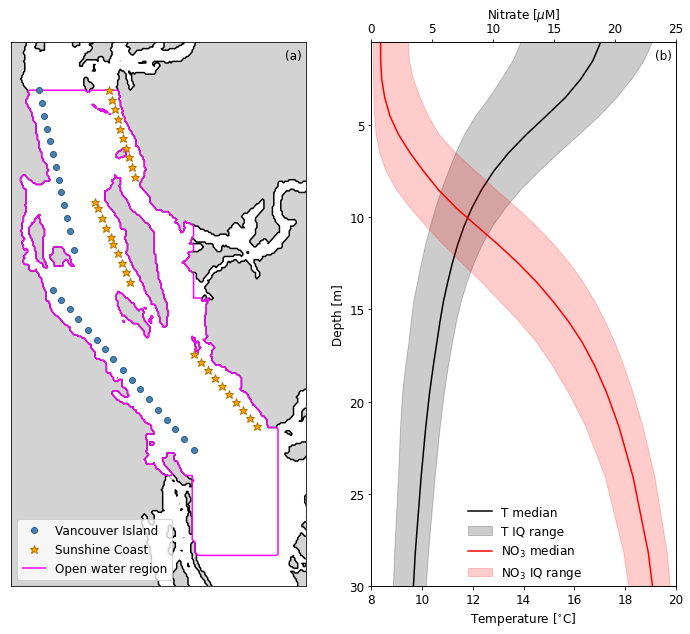

In [45]:
# Plot regions
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
ax = axs[0]
x, y = tmask.x[slice(*subdomain[:2])].values, tmask.y[slice(*subdomain[2:])].values
ax.set_xlim([110, 320])
ax.set_ylim([400, 740])
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_aspect(5/4.4)
landmask = np.copy(tmask.values[slice(*subdomain[2:]), slice(*subdomain[:2])])
ax.contourf(x, y, landmask, levels=[-0.01, 0.01], colors='lightgray')
ax.contour(x, y, landmask, levels=[-0.01, 0.01], colors='k')
landmask[:120, :] = 0
landmask[410:, :] = 0
landmask[:170, :130] = 0
landmask[:, 190:] = 0
landmask[280:, 130:] = 0
c = ax.contour(x, y, landmask, levels=[-0.01, 0.01], colors='magenta')
c.collections[1].set_label('Open water region')
for section, label, color, marker, ms in zip(sections, ['Vancouver Island', 'Sunshine Coast'], ['steelblue', 'orange'], ['o', '*'], [6, 9]):
    ax.plot(section['x'], section['y'], marker, ms=ms, mec=np.array(colors.to_rgb(color))*0.7, mfc=color, label=label)
ax.legend(loc=3)
ax.text(0.93, 0.97, '(a)', transform=ax.transAxes)

ax2 = axs[1].twiny()
axs[1].set_ylim([30, 0.5])
axs[1].set_ylabel('Depth [m]')
for ax, var, xlim, label, xlabel, color, ypos in zip(
    [axs[1], ax2], ['votemper', 'nitrate'], [(8, 20), (0, 25)], ['T', 'NO$_3$'], ['Temperature [$^{\circ}$C]', 'Nitrate [$\mu$M]'], ['k', 'r'], [0.08, 0],
):
    percentiles = np.percentile(profiles2[var], [25, 50, 75], axis=(0, 2))
    ax.fill_betweenx(deptht, *percentiles[(0, 2), :], ec=color, fc=color, alpha=0.2, label=f'{label} IQ range')
    ax.plot(percentiles[1, :], deptht, '-', color=color, label=f'{label} median')
    ax.set_xlim(xlim)
    ax.set_xlabel(xlabel)
    ax.legend(loc=(0.3, ypos), frameon=False)
ax.text(0.93, 0.97, '(b)', transform=ax.transAxes)
#fig.savefig('/home/bmoorema/Desktop/revision_figs/spatialavgs_profiles.pdf', bbox_inches='tight')